# Fuzzy Sarcasm Classifier Demo

This notebook demonstrates training a binary sarcasm classifier and using fuzzy trapezoidal membership functions to classify how sarcastic a comment is.

For each comment the system outputs:
- The sarcasm probability (a value in [0, 1])
- Membership degrees for three fuzzy sets: **Unlikely**, **Probably**, and **Highly Likely**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Current Working Directory:", os.getcwd())
# Add the project root (one level up) to the sys.path
if os.getcwd()[-9:] == 'notebooks':
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    os.chdir(project_root)
print("Current Working Directory:", os.getcwd())

%matplotlib inline

Current Working Directory: /Users/tsvetan/fmi/fuzzy/FuzzySarcasmV2/notebooks
Current Working Directory: /Users/tsvetan/fmi/fuzzy/FuzzySarcasmV2


In [2]:
from src.data_loader import load_train_test
from src.sarcasm_classifier import SarcasmClassifier
from src.utils import preprocess_texts

## Load Data

Assuming the `data` folder contains `train.csv` and `test.csv` with columns `comment` and `label`.
For demonstration, dummy data will be created if these files do not exist.

Note: A comment is considered sarcastic only if its label is `'sarcasm'`.

In [3]:
train_path = os.path.join('data', 'train.csv')
test_path = os.path.join('data', 'test.csv')

# Create dummy data if files do not exist
if not os.path.exists(train_path):
    dummy_train = pd.DataFrame({
        'comment': [
            'I love this product, it works amazingly!',
            'Oh great, another rainy day. Just what I needed.',
            'Sure, because that makes perfect sense... not!',
            'The metaphor in this poem is absolutely breathtaking.'
        ],
        'label': ['normal', 'irony', 'sarcasm', 'figurative']
    })
    dummy_train.to_csv(train_path, index=False)

if not os.path.exists(test_path):
    dummy_test = pd.DataFrame({
        'comment': [
            'I am so excited about this new update!',
            'Oh, fantastic. Another update that breaks everything.'
        ],
        'label': ['normal', 'sarcasm']
    })
    dummy_test.to_csv(test_path, index=False)

train_df, test_df = load_train_test(train_path, test_path)
print("Training data:")
display(train_df)

print("\nTest data:")
display(test_df)


Training data:


,comment,label
0,Be aware dirty step to get money #staylight ...,figurative
1,#sarcasm for #people who don't understand #diy...,figurative
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative
3,@wilw Why do I get the feeling you like games?...,figurative
4,-@TeacherArthurG @rweingarten You probably jus...,figurative
...,...,...
81403,Photo: Image via We Heart It http://t.co/ky8Nf...,sarcasm
81404,I never knew..I better put this out to the Uni...,sarcasm
81405,hey just wanted to say thanks @ puberty for le...,sarcasm
81406,I'm sure coverage like the Fox News Special “T...,sarcasm



Test data:


,comment,label
0,no one ever predicted this was going to happen...,figurative
1,@Stooshie its as closely related as Andrews or...,figurative
2,I find it ironic when Vegans say they love foo...,figurative
3,Quick rt that throwing money vine I've not see...,figurative
4,"yep, keep adding me to your #devops lists.... ...",figurative
...,...,...
8123,Why yes I will totally submit my photos to a s...,sarcasm
8124,Test on a Saturday! Thank you uni! #sarcasm @ ...,sarcasm
8125,Listening to @StephenKing's Misery isn't at al...,sarcasm
8126,@mmcpatt There you go being kind again #sarcas...,sarcasm


## Preprocess Data

Clean the text data before training.

In [8]:
train_df['clean_comment'] = preprocess_texts(train_df['comment'])
test_df['clean_comment'] = preprocess_texts(test_df['comment'])

print("Training data before / after cleanup:")
display(train_df[['comment', 'clean_comment']])
print("Test data before / after cleanup:")
display(test_df[['comment', 'clean_comment']])

Training data before / after cleanup:


,comment,clean_comment
0,Be aware dirty step to get money #staylight ...,be aware dirty step to get money
1,#sarcasm for #people who don't understand #diy...,for who dont understand
2,@IminworkJeremy @medsingle #DailyMail readers ...,readers being sensible as always
3,@wilw Why do I get the feeling you like games?...,why do i get the feeling you like games
4,-@TeacherArthurG @rweingarten You probably jus...,you probably just missed the text
...,...,...
81403,Photo: Image via We Heart It http://t.co/ky8Nf...,photo image via we heart it
81404,I never knew..I better put this out to the Uni...,i never knewi better put this out to the unive...
81405,hey just wanted to say thanks @ puberty for le...,hey just wanted to say thanks puberty for lett...
81406,I'm sure coverage like the Fox News Special “T...,im sure coverage like the fox news special the...


Test data before / after cleanup:


,comment,clean_comment
0,no one ever predicted this was going to happen...,no one ever predicted this was going to happen
1,@Stooshie its as closely related as Andrews or...,its as closely related as andrews original cla...
2,I find it ironic when Vegans say they love foo...,i find it ironic when vegans say they love food
3,Quick rt that throwing money vine I've not see...,quick rt that throwing money vine ive not seen...
4,"yep, keep adding me to your #devops lists.... ...",yep keep adding me to your lists
...,...,...
8123,Why yes I will totally submit my photos to a s...,why yes i will totally submit my photos to a s...
8124,Test on a Saturday! Thank you uni! #sarcasm @ ...,test on a saturday thank you uni griffith univ...
8125,Listening to @StephenKing's Misery isn't at al...,listening to s misery isnt at all disconcerting
8126,@mmcpatt There you go being kind again #sarcas...,there you go being kind again


## Train the Sarcasm Classifier

We train the classifier on the clean comments. A comment is considered sarcastic if its label is `'sarcasm'`.

In [9]:
# Initialize and train the classifier
sarcasm_clf = SarcasmClassifier()
sarcasm_clf.train(train_df['clean_comment'], train_df['label'])

print("Sarcasm classifier trained.")

Sarcasm classifier trained.


## Make Fuzzy Sarcasm Predictions on Test Data

For each test comment, we predict the sarcasm probability and compute fuzzy membership degrees for:
- Unlikely
- Probably
- Highly Likely

In [10]:
test_comments = test_df['clean_comment'].tolist()
fuzzy_results = sarcasm_clf.classify_fuzzy(test_comments)

for comment, result in zip(test_df['comment'], fuzzy_results):
    print(f"Comment: {comment}")
    print(f"Sarcasm Probability: {result['sarcasm_probability']:.2f}")
    print(f"""Membership Degrees: Unlikely: {result['unlikely']:.2f},  
              Probably: {result['probably']:.2f},  
              Highly Likely: {result['highly_likely']:.2f}""")
    print('---')

Comment: no one ever predicted this was going to happen. #sarcasm https://t.co/eeJsozDYKc
Sarcasm Probability: 0.41
Membership Degrees: Unlikely: 0.47,  
              Probably: 0.53,  
              Highly Likely: 0.00
---
Comment: @Stooshie its as closely related as Andrews original claim that evolution and entropy #sarcasm
Sarcasm Probability: 0.33
Membership Degrees: Unlikely: 0.87,  
              Probably: 0.13,  
              Highly Likely: 0.00
---
Comment: I find it ironic when Vegans say they love food #Irony
Sarcasm Probability: 0.04
Membership Degrees: Unlikely: 1.00,  
              Probably: 0.00,  
              Highly Likely: 0.00
---
Comment: Quick rt that throwing money vine I've not seen it 30 times in the last 30 seconds #sarcasm
Sarcasm Probability: 0.33
Membership Degrees: Unlikely: 0.87,  
              Probably: 0.13,  
              Highly Likely: 0.00
---
Comment: yep, keep adding me to your #devops lists.... #justsaying #infosec #irony
Sarcasm Probability: 0

## Visualize Fuzzy Membership Functions

Let's visualize the three trapezoidal membership functions and mark the sarcasm probability of the first test comment.

[0.80986953 0.62250513 0.1322167 ]


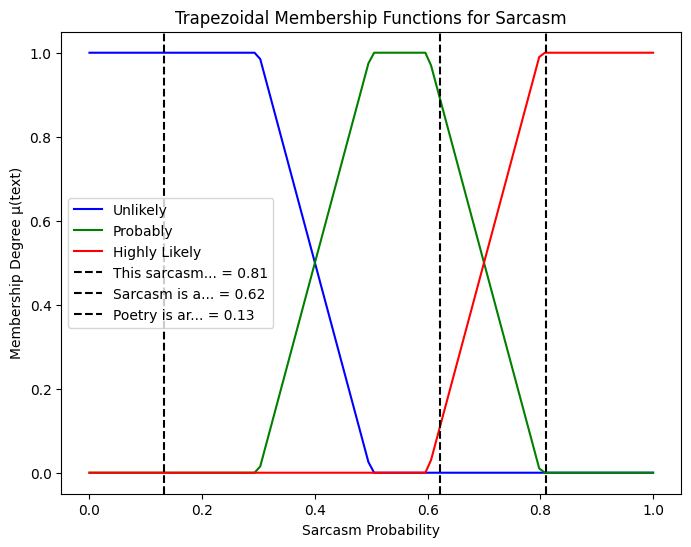

[{'sarcasm_probability': np.float64(0.8098695314987909), 'unlikely': np.float64(0.0), 'probably': np.float64(0.0), 'highly_likely': np.float64(1.0)}, {'sarcasm_probability': np.float64(0.6225051290124867), 'unlikely': np.float64(0.0), 'probably': np.float64(0.8874743549375665), 'highly_likely': np.float64(0.11252564506243341)}, {'sarcasm_probability': np.float64(0.13221669965351646), 'unlikely': np.float64(1.0), 'probably': np.float64(0.0), 'highly_likely': np.float64(0.0)}]


In [29]:
# Retrieve x values and membership functions from the classifier
x = sarcasm_clf.x_sarcasm
mf_unlikely = sarcasm_clf.mf_unlikely
mf_probably = sarcasm_clf.mf_probably
mf_highly_likely = sarcasm_clf.mf_highly_likely

# Get the sarcasm probability for the first test comment
first_prob = sarcasm_clf.predict_proba([test_df['clean_comment'].iloc[0]])[0]
second_prob = sarcasm_clf.predict_proba(['This sarcasm is not sarcasm'])[0]
third_prob = sarcasm_clf.predict_proba(['Sarcasm is art'])[0]

demo_texts = [
    'This sarcasm is not sarcasm',
    'Sarcasm is art',
    'Poetry is art'
]
demo_probs = sarcasm_clf.predict_proba(demo_texts)
print(demo_probs)
fuzzy_probs = sarcasm_clf.classify_fuzzy(demo_texts)
plt.figure(figsize=(8, 6))
plt.plot(x, mf_unlikely, 'b', linewidth=1.5, label='Unlikely')
plt.plot(x, mf_probably, 'g', linewidth=1.5, label='Probably')
plt.plot(x, mf_highly_likely, 'r', linewidth=1.5, label='Highly Likely')
#plt.axvline(fuzzy_probs[1].sarcasm_probability,color='p', linestyle='.', label=f'{demo_texts[1][:12] +'...'} = {fuzzy_probs[1].sarcasm_probability:.2f}')
for i in range(len(demo_texts)):
    plt.axvline(demo_probs[i],color='k', linestyle='--', label=f'{demo_texts[i][:12] +'...'} = {demo_probs[i]:.2f}')

plt.title('Trapezoidal Membership Functions for Sarcasm')
plt.xlabel('Sarcasm Probability')
plt.ylabel('Membership Degree μ(text)')
plt.legend()
plt.show()
print(fuzzy_probs)